In [1]:
import numpy as np
import tonic
import tonic.transforms as transforms
import pandas as pd
from torch.utils.data import Dataset, DataLoader
#from tonic.dataset import Dataset
from typing import Callable, Optional
import torch
import matplotlib.pyplot as plt
from torchvision.ops import masks_to_boxes
from torchvision.utils import draw_bounding_boxes

from tqdm.notebook import tqdm

#### TODO
- [x] Voxel grid

In [2]:
import sys
sys.path.append("./mnist_sg_cnn")

In [3]:
import utils
import snn_utils
import base_model
import lenet_decolle_model

In [4]:
dir = "/media/user/EVIMO/raw/imo/eval/scene15_dyn_test_01/left_camera/ground_truth_000000"
sensor_size = [640, 480, 2]
batch_size = 4
num_bins_per_frame = 16 # T = 100
framerate = 200
epochs=20

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [25]:
class EVIMO(Dataset):
    def __init__(self,
                 dir: str,
                 item_to_find: int,
                 num_bins_per_frame: int,
                 #start_idx: int,
                ):
        self.dir = dir
        self.item_to_find = item_to_find
        self.num_bins_per_frame = num_bins_per_frame
        self.length = np.load(self.dir + "/length.npy")
        #print(self.length)
        #self.start_idx = start_idx


    def __getitem__(self, index):
        item = np.load(self.dir + "/" + str(index) + ".npy", allow_pickle=True).tolist()

        
        obj_ids = item["objs_in_mask"][1:]
        if self.item_to_find in obj_ids:
            id = obj_ids.tolist().index(self.item_to_find)
            detection_masks = torch.from_numpy(item["mask"]) == torch.from_numpy(np.asarray(obj_ids[:, None, None]))
            boxes = masks_to_boxes(detection_masks)
            box = boxes[id]
        else:
            box = torch.zeros([4])

        

        #target = np.tile(target, (self.num_bins_per_frame, 1))
        #print(item["events"].dtype)
        events = np.asarray(item["events"])
        #target = target

        frame_transform = transforms.Compose([# transforms.Denoise(filter_time=0.01),
                                       transforms.ToVoxelGrid(sensor_size=sensor_size,
                                                          n_time_bins=self.num_bins_per_frame)
                                      ])

        # #transform = transforms.ToFrame(sensor_size=sensor_size, )
        events = frame_transform(events)

        #return {"data": events, "targets": target}
        targets = {"boxes": box, "labels": 1}
        return events, targets

    def __len__(self) -> int:
        return self.length # - self.start_idx
    
    

In [26]:
tonic_dataset = EVIMO(dir="./data/EVIMO/left_cam/scene13_test5", item_to_find=23, num_bins_per_frame=num_bins_per_frame)

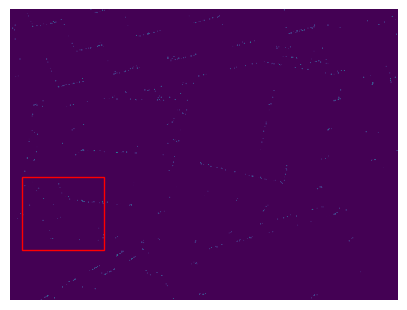

In [29]:
bins, targets = tonic_dataset[0]
bins.shape
from modified_tonic_animation import plot_animation
from IPython.display import HTML

HTML(plot_animation(bins, targets["boxes"]).to_jshtml())


In [30]:
trainloader = DataLoader(tonic_dataset, batch_size=batch_size, shuffle=False)

In [32]:


loss = torch.nn.SmoothL1Loss()

def decolle_loss(r, s, tgt):
    loss_tv = 0
    for i in range(len(r)):
        if r[i].shape != tgt.shape:
            print(f"Loss Readout shape : {r[i].shape}")
            print(f"Loss Target shape : {tgt.shape}")
        loss_tv += loss(r[i],tgt) 
    return loss_tv


convnet_sg = lenet_decolle_model.LenetDECOLLE(out_channels=4,
                    Nhid=[64, 128, 256], #Number of convolution channels
                    Mhid=[256, 512],
                    kernel_size=[8, 16, 32],
                    pool_size=[4, 8, 8],
                    input_shape=[1, 480, 640],  # data.shape[1:],
                    alpha=[.95],
                    alpharp=[.65],
                    beta=[.92],
                    num_conv_layers=3,
                    num_mlp_layers=2,
                    lc_ampl=0.5).to(device)

#net = lenet_decolle_model.LenetDECOLLE(Nhid=[1,8],Mhid=[32,64],out_channels=2, input_shape=[2, 480, 640]).to(device)

#convnet_sg

data, target = next(iter(trainloader))
data_d = data.to(device)
convnet_sg.init_parameters(data_d) # Modifies readout dim

LAYER SIZE: 1210944
STDV: 0.000454368247933539
LAYER SIZE: 34048
STDV: 0.002709718654762875
LAYER SIZE: 512
STDV: 0.022097086912079608
LAYER SIZE: 256
STDV: 0.03125
LAYER SIZE: 512
STDV: 0.022097086912079608


In [9]:
from tqdm.notebook import tqdm
from torchvision.ops import box_iou

opt_conv = torch.optim.Adamax(convnet_sg.get_trainable_parameters(), lr=1e-9, betas=[0., .95])
for e in range(epochs):        
    error = []
    accuracy=[]
    for data, label in tqdm(iter(trainloader), desc=f"Epoch {e}"):
        convnet_sg.train()
        loss_hist = 0
        data_d = data.to(device)
        label_d = label.to(device)
        convnet_sg.init(data_d, burnin=10)
        readout = 0

        #print(label_d)
        #print(label_d.shape)
        #break

        data_d = data_d.transpose(0, 1)
        
        for n in range(num_bins_per_frame):
           # print(f"Data shape: {data_d[n].shape}, overall: {data_d.shape}")
            st, rt, ut = convnet_sg.forward(data_d[n])
            #print("Readout")
            #print(len(rt), rt[0].shape, rt[1].shape, rt[2].shape)
            #print(f"Label: {label_d[n].shape} overall {label_d.shape}")
            #print(label_d[n].shape)
            #print(label_d[n])
            loss_tv = decolle_loss(rt, st, label_d)
            loss_tv.backward()
            opt_conv.step()
            opt_conv.zero_grad()
            loss_hist += loss_tv
            readout += rt[-1]

        print("READOUT")
        print(readout)

        print("LABEL")
        print(label_d)

        #print("IoU")
        IoU = torch.diagonal(box_iou(label_d, readout))
        #print(IoU)

        correctly_found = torch.round(IoU)  # IoUs > 0.5 are 1's (correct), <= 0.5 are 0's (wrong)
            
        #error += (readout.argmax(axis=1)!=label_d.argmax(axis=1)).float()
        #accuracy+=(readout.argmax(axis=1)==label_d.argmax(axis=1)).float()
        #print(correctly_found)


        error += (correctly_found == 0).float()
        accuracy += correctly_found.float()
        
    print('Training Error', torch.mean(torch.Tensor(error)).data)
    print('Training accuracy', torch.mean(torch.Tensor(accuracy)).data)     
    print('Epoch', e, 'Loss', loss_hist.data)
    PATH = './evimo_obj_det.pth'
    torch.save(convnet_sg.state_dict(), PATH)

NameError: name 'convnet_sg' is not defined

In [ ]:
pt = [[1, 1, 3, 3]]
pt = torch.from_numpy(np.asarray(pt))
pt2 = [[1, 1, 3, 4]]
pt2 = torch.from_numpy(np.asarray(pt2))

box_iou(pt, pt2)

In [ ]:
pt = [[1, 1, 3, 3],
     [1, 1, 3, 4]]
pt = torch.from_numpy(np.asarray(pt))

torch.diagonal(box_iou(pt, pt))

In [12]:
from torchvision.models.detection.anchor_utils import DefaultBoxGenerator

In [13]:
anchor_generator = DefaultBoxGenerator([[480, 640]], 1, 1)

In [14]:
data, target = next(iter(trainloader))
data_d = data.to(device, dtype=torch.float)

In [15]:
convnet_sg.init(data_d, burnin=10)
features = convnet_sg(data_d.transpose(0, 1))

In [16]:
features[0][0].shape

torch.Size([4, 64, 119, 159])

In [17]:
len(features)

3

In [18]:
len(features[0])

5

In [19]:
num_anchors = anchor_generator.num_anchors_per_location()
num_anchors

[6]

In [20]:
from SSDHeads import *
# out_channels, num_anchors, args.num_classes
ssdhead = SSDHead([4], num_anchors, 1)

In [22]:
import torchvision.models.detection._utils as det_utils

In [24]:
num_classes = 1
box_coder_weights = [10.0, 10.0, 5.0, 5.0]
iou_threshold = 0.50

class ObjDetModule(nn.Module):
    def __init__(self):

        self.backbone = lenet_decolle_model.LenetDECOLLE(out_channels=4,
                    Nhid=[64, 128, 256], #Number of convolution channels
                    Mhid=[256, 512],
                    kernel_size=[8, 16, 32],
                    pool_size=[4, 8, 8],
                    input_shape=[1, 480, 640],  # data.shape[1:],
                    alpha=[.95],
                    alpharp=[.65],
                    beta=[.92],
                    num_conv_layers=3,
                    num_mlp_layers=2,
                    lc_ampl=0.5).to(device)

        data, target = next(iter(trainloader))
        data_d = data.to(device)
        self.backbone.init_parameters(data_d) # Modifies readout dim


        
        self.anchor_generator = DefaultBoxGenerator([[480, 640]], 1, 1)

        out_channels = [4]
        assert len(out_channels) == len(self.anchor_generator.aspect_ratios)

        
        num_anchors = self.anchor_generator.num_anchors_per_location()
        self.head = SSDHead(out_channels, num_anchors, num_classes)

        self.box_coder = det_utils.BoxCoder(weights=box_coder_weights)
        self.proposal_matcher = det_utils.SSDMatcher(iou_threshold)

    def forward(self, events):
        
        features = self.backbone(events)

        
        head_outputs = self.head(features)
        return features, head_outputs

    def step(batch, mode):
        events, targets = batch

        features, head_outputs = self.forward(events)
        
        if mode == "train":
            self.backbone.train()
            loss_hist = 0
            data_d = data.to(device)
            label_d = label.to(device)
            self.backbone.init(data_d, burnin=10)
            readout = 0
    
            data_d = data_d.transpose(0, 1)
            for n in range(num_bins_per_frame):
                st, rt, ut = self.backbone.forward(data_d[n])
                loss_tv = decolle_loss(rt, st, label_d)
                loss_tv.backward()
                opt_conv.step()
                opt_conv.zero_grad()
                loss_hist += loss_tv
                readout += rt[-1]
    
            print("READOUT")
            print(readout)
    
            print("LABEL")
            print(label_d)
    
            #print("IoU")
            IoU = torch.diagonal(box_iou(label_d, readout))
            #print(IoU)
    
            correctly_found = torch.round(IoU)  # IoUs > 0.5 are 1's (correct), <= 0.5 are 0's (wrong)
                
            #error += (readout.argmax(axis=1)!=label_d.argmax(axis=1)).float()
            #accuracy+=(readout.argmax(axis=1)==label_d.argmax(axis=1)).float()
            #print(correctly_found)
    
    
            error += (correctly_found == 0).float()
            accuracy += correctly_found.float()